In [7]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [8]:
# set number of assets (= number of qubits)
num_assets = 13
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

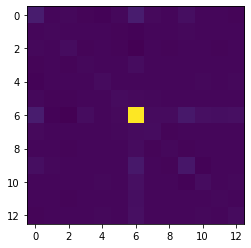

In [9]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [10]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.015284386652 x_0 + 0.000780952145 x_1 - 0.000517920547 x_2
      - 0.000870005837 x_3 - 0.010323519990 x_4 + 0.001666841256 x_5
      - 0.027213819622 x_6 - 0.000348237886 x_7 + 0.001120764278 x_8
      + 0.012440342693 x_9 - 0.001609199513 x_10 - 0.003794418593 x_11
      + 0.005877766869 x_12 + [ 0.002541388592 x_0^2 + 0.000146804433 x_0*x_1
      + 0.000257201062 x_0*x_2 - 0.000199722426 x_0*x_3 - 0.000626398406 x_0*x_4
      + 0.000478782112 x_0*x_5 + 0.005160155269 x_0*x_6 + 0.000564541457 x_0*x_7
      - 0.000049255458 x_0*x_8 + 0.001754659006 x_0*x_9
      - 0.000083775278 x_0*x_10 + 0.000164466673 x_0*x_11
      - 0.000175818183 x_0*x_12 + 0.000258486713 x_1^2 + 0.000106085519 x_1*x_2
      + 0.000088963242 x_1*x_3 - 0.000026490315 x_1*x_4 - 0.000159895987 x_1*x_5
      - 0.000517341706 x_1*x_6 - 0.000034553283 x_1*x_7 + 0.000146005788 x_1*x_8
      + 0.0002

In [11]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [12]:
%%time
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0.], value -0.0294

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 1 0 1 0 0 1 1 0 1]	-0.0040		0.4867
[0 0 0 1 0 1 0 1 1 0 1 1 0]	-0.0023		0.3108
[1 0 0 0 0 0 1 0 1 1 1 1 0]	-0.0024		0.1598
[1 0 0 0 0 0 1 0 1 1 1 0 0]	1.1253		0.0051
[0 0 0 1 0 1 0 1 1 1 1 1 0]	1.1357		0.0033
[0 0 0 0 0 0 1 0 1 1 1 1 0]	1.1331		0.0024
[0 1 0 1 0 1 0 1 1 0 1 1 0]	1.1236		0.0021
[1 0 0 0 0 0 1 1 1 1 1 1 0]	1.1235		0.0019
[1 0 0 0 1 0 1 0 0 1 1 1 1]	1.1185		0.0013
[0 0 0 0 0 1 1 0 1 1 1 1 0]	0.0106		0.0013
[1 0 0 0 1 0 1 0 0 1 1 0 0]	1.1135		0.0013
[1 0 0 0 0 0 1 0 1 1 0 1 0]	1.1233		0.0011
[1 0 0 0 0 0 0 0 1 1 1 1 0]	1.1210		0.0011
[0 0 0 1 0 1 0 1 0 0 1 0 1]	1.1315		0.0011
[0 0 0 1 0 1 1 1 1 0 1 1 0]	1.1213		0.0010
[1 0 0 1 0 1 0 1 1 0 1 1 0]	1.1091		0.0010
[1 0 0 1 1 0 1 0 0 1 1 0 1]	1.1211		0.0009
[1 1 0 0 1 0 1 0 0 1 1 0 1]	1.1219		0.0009
[0 0 0 1 1 1 0

[1 0 0 1 1 1 0 1 0 1 1 0 0]	1.1155		0.0000
[0 0 1 1 1 1 0 1 0 1 1 0 1]	4.5099		0.0000
[1 0 0 1 0 1 0 1 0 1 1 0 1]	1.1318		0.0000
[1 0 0 0 0 0 0 0 1 1 1 1 1]	0.0023		0.0000
[0 0 0 1 1 0 0 1 1 0 1 0 1]	-0.0040		0.0000
[0 0 0 0 0 0 1 0 1 1 1 0 0]	4.5108		0.0000
[0 0 0 1 1 1 0 0 0 1 1 0 1]	0.0099		0.0000
[0 1 0 0 0 1 0 1 1 0 1 1 0]	-0.0007		0.0000
[1 0 0 1 1 0 0 1 0 0 0 0 1]	1.1064		0.0000
[0 0 0 0 1 0 0 1 0 0 1 0 1]	4.4953		0.0000
[1 0 0 0 0 0 1 0 0 1 1 0 0]	4.4985		0.0000
[1 0 0 0 0 1 1 1 1 1 0 1 0]	1.1268		0.0000
[1 0 1 0 0 1 1 0 1 1 1 1 0]	4.4991		0.0000
[1 0 0 0 0 0 1 0 1 1 1 1 1]	1.1300		0.0000
[1 0 0 0 0 0 1 1 1 0 1 1 0]	-0.0174		0.0000
[1 0 0 0 0 0 1 0 1 0 0 1 0]	4.4819		0.0000
[1 0 0 1 0 0 1 1 1 1 1 1 0]	4.4984		0.0000
[1 0 0 0 0 0 1 0 1 1 1 0 1]	0.0076		0.0000
[1 0 1 0 0 0 1 1 1 1 1 1 0]	4.4976		0.0000
[1 0 0 0 1 1 1 0 1 1 1 1 0]	4.4902		0.0000
[0 0 1 1 1 0 0 1 0 0 1 1 1]	1.1160		0.0000
[0 0 0 1 0 1 0 1 0 0 0 0 1]	4.5074		0.0000
[0 1 0 1 1 1 0 1 0 0 1 1 1]	4.4943		0.0000
[1 0 0 1

[1 0 0 1 1 1 0 0 0 1 1 0 1]	1.1214		0.0000
[0 1 0 1 0 0 1 1 1 0 1 1 0]	1.1194		0.0000
[0 0 0 1 1 0 0 1 0 0 0 0 0]	10.1140		0.0000
[0 0 0 0 0 0 1 1 1 1 1 1 1]	1.1412		0.0000
[1 0 1 0 0 1 1 0 1 1 0 1 0]	1.1247		0.0000
[0 0 0 0 1 0 1 1 0 1 1 0 1]	0.0077		0.0000
[0 0 0 1 0 1 1 1 0 0 1 1 0]	-0.0055		0.0000
[1 0 0 1 0 1 0 1 0 0 0 0 1]	1.1188		0.0000
[0 0 1 1 1 0 1 1 0 0 1 0 1]	1.1168		0.0000
[1 0 0 1 0 1 0 1 1 0 0 1 1]	1.1165		0.0000
[1 0 0 1 0 1 0 1 1 0 0 0 0]	1.1138		0.0000
[1 1 0 1 0 1 0 1 1 0 1 0 0]	1.1137		0.0000
[1 1 0 0 0 1 0 0 1 1 1 1 0]	1.1243		0.0000
[1 1 1 1 1 1 0 1 0 0 1 0 1]	10.1085		0.0000
[0 0 0 1 0 1 1 1 0 0 1 1 1]	1.1271		0.0000
[0 0 0 0 1 0 1 0 0 1 1 1 1]	0.0044		0.0000
[0 0 0 1 1 1 0 0 1 0 1 0 1]	-0.0019		0.0000
[1 0 1 1 1 1 0 0 0 0 1 0 1]	1.1071		0.0000
[1 0 0 1 0 0 0 0 0 0 1 0 1]	4.4899		0.0000
[0 0 0 0 0 0 0 0 0 1 1 1 0]	10.1327		0.0000
[0 0 0 1 0 0 0 1 0 1 1 1 1]	0.0140		0.0000
[0 0 0 0 0 1 1 1 1 1 0 1 0]	0.0118		0.0000
[0 1 0 1 1 1 1 1 0 0 1 0 1]	4.4959		0.0000
[0 0 0

[0 0 1 0 0 0 1 1 1 1 1 1 0]	1.1328		0.0000
[0 1 0 0 0 1 1 0 1 1 1 1 0]	1.1363		0.0000
[1 0 0 1 1 1 0 0 0 1 1 1 1]	4.4929		0.0000
[0 1 0 0 0 1 1 0 1 1 0 1 0]	0.0119		0.0000
[1 0 0 1 0 1 0 0 0 0 1 1 1]	-0.0112		0.0000
[1 1 0 0 0 0 0 0 1 1 1 0 0]	1.1258		0.0000
[0 1 0 1 0 1 0 1 1 0 0 0 0]	1.1284		0.0000
[0 0 1 1 0 1 0 0 1 0 1 1 0]	-0.0030		0.0000
[0 0 0 1 0 0 0 1 1 1 1 0 1]	0.0187		0.0000
[0 0 0 1 0 1 0 0 0 0 1 0 0]	10.1246		0.0000
[1 0 0 0 1 1 1 0 0 0 1 0 1]	-0.0172		0.0000
[1 0 1 0 1 0 1 0 0 1 0 0 1]	-0.0043		0.0000
[1 0 0 1 1 1 0 1 1 1 1 1 1]	17.9943		0.0000
[0 0 1 1 1 1 0 0 0 0 1 1 1]	1.1177		0.0000
[0 0 0 0 0 0 0 0 1 0 1 1 0]	10.1210		0.0000
[0 0 1 0 0 1 0 1 1 0 1 1 0]	-0.0019		0.0000
[0 0 0 1 0 1 1 1 1 1 1 0 0]	1.1391		0.0000
[1 0 0 0 1 1 0 0 1 1 1 1 0]	1.1132		0.0000
[0 0 0 1 0 1 0 1 0 0 0 0 0]	10.1260		0.0000
[1 1 0 0 1 0 1 0 0 0 1 0 1]	-0.0192		0.0000
[0 0 0 0 0 1 0 0 1 1 0 1 0]	4.5126		0.0000
[0 0 1 0 0 0 1 0 1 1 1 0 0]	1.1350		0.0000
[0 0 0 1 0 0 0 0 0 0 1 1 0]	10.1190		0.0000


[0 0 0 0 0 0 1 1 0 1 1 0 0]	4.5097		0.0000
[0 1 0 1 1 1 0 1 1 1 1 0 1]	10.1372		0.0000
[0 0 0 0 0 1 1 0 1 1 0 1 1]	0.0186		0.0000
[0 0 0 0 1 0 1 0 1 1 1 0 1]	0.0087		0.0000
[1 0 0 0 1 1 1 0 0 1 1 1 0]	1.1136		0.0000
[0 0 1 1 0 0 0 1 1 0 1 1 1]	1.1266		0.0000
[1 0 1 0 0 0 1 0 1 0 1 0 0]	1.1086		0.0000
[1 0 1 1 1 1 0 1 0 0 1 0 0]	1.1013		0.0000
[1 0 0 0 1 1 1 0 0 1 1 0 0]	-0.0088		0.0000
[0 0 0 0 1 1 1 0 1 1 1 0 0]	0.0036		0.0000
[1 0 0 1 0 0 1 0 1 1 1 0 1]	1.1327		0.0000
[1 0 0 1 1 1 0 1 1 1 1 0 0]	4.4915		0.0000
[0 0 0 1 1 0 0 0 1 0 1 1 1]	-0.0076		0.0000
[0 1 0 1 0 0 0 1 1 1 1 1 1]	4.5161		0.0000
[1 0 0 0 1 0 1 0 1 1 0 0 0]	1.1157		0.0000
[1 0 0 1 0 0 0 0 1 1 1 0 0]	1.1239		0.0000
[1 0 0 0 0 1 1 0 1 0 0 1 0]	1.1097		0.0000
[0 1 0 0 1 0 0 1 0 0 1 0 1]	1.1213		0.0000
[1 1 0 0 0 0 1 1 0 1 1 1 0]	1.1227		0.0000
[0 0 0 0 0 1 1 1 1 0 1 1 0]	-0.0037		0.0000
[1 1 0 1 1 0 1 1 0 0 1 0 1]	4.4817		0.0000
[1 0 0 1 0 1 0 0 0 0 1 1 0]	1.1074		0.0000
[0 0 0 1 0 1 0 0 0 0 0 0 1]	10.1321		0.0000
[0 1 0

[1 0 0 1 1 0 1 1 0 1 1 0 0]	1.1146		0.0000
[0 0 0 1 0 0 1 1 1 0 1 0 1]	0.0040		0.0000
[1 0 0 1 0 0 0 0 0 1 1 0 1]	1.1290		0.0000
[0 0 1 0 0 1 0 0 1 1 1 1 0]	0.0108		0.0000
[0 0 1 1 1 0 0 1 0 0 0 1 1]	-0.0081		0.0000
[1 1 0 0 0 0 1 0 1 0 0 1 0]	1.1078		0.0000
[0 0 0 1 0 0 1 1 1 1 1 0 0]	0.0116		0.0000
[1 0 0 1 0 1 0 1 0 1 0 0 1]	0.0082		0.0000
[1 0 0 0 0 1 1 1 1 1 0 1 1]	4.5090		0.0000
[1 0 0 1 0 1 1 0 1 1 0 0 0]	0.0035		0.0000
[0 1 1 1 1 1 0 1 1 0 1 0 1]	10.1235		0.0000
[0 0 0 0 0 1 0 1 1 1 0 1 0]	1.1379		0.0000
[0 0 0 1 1 1 1 0 0 1 1 0 1]	1.1347		0.0000
[0 1 0 1 0 0 0 1 1 0 0 1 1]	0.0040		0.0000
[1 0 1 0 0 0 0 1 1 1 1 1 0]	1.1214		0.0000
[0 1 0 1 0 0 1 1 0 0 1 0 1]	0.0029		0.0000
[0 0 0 0 0 0 0 0 0 1 1 0 0]	18.0112		0.0000
[0 0 1 1 0 0 0 1 0 0 1 1 0]	1.1192		0.0000
[0 0 0 1 0 1 1 1 1 0 0 0 0]	1.1241		0.0000
[1 0 0 0 1 1 1 1 0 1 1 0 1]	4.4998		0.0000
[0 1 0 1 0 0 0 1 1 0 0 0 0]	4.5013		0.0000
[0 0 1 1 1 0 0 1 1 0 1 1 1]	4.4920		0.0000
[1 0 0 0 1 1 0 1 1 0 1 0 1]	1.1099		0.0000
[1 1 0 0

[0 0 0 1 0 1 0 0 1 1 1 0 0]	1.1391		0.0000
[0 1 0 1 1 1 0 0 0 0 1 1 0]	-0.0126		0.0000
[0 1 0 1 0 1 0 1 1 1 1 0 1]	4.5218		0.0000
[1 0 0 1 0 0 0 0 1 0 1 0 0]	4.4850		0.0000
[1 0 0 1 1 0 1 0 0 1 1 1 0]	1.1110		0.0000
[1 0 0 0 1 1 0 1 0 0 0 0 1]	1.1096		0.0000
[0 1 0 1 1 1 0 0 0 0 0 0 1]	1.1235		0.0000
[0 0 0 0 0 1 0 0 1 1 0 0 0]	10.1411		0.0000
[1 0 0 1 0 1 0 1 1 0 0 0 1]	-0.0049		0.0000
[0 1 0 1 1 0 0 1 1 0 1 0 1]	1.1220		0.0000
[1 0 0 1 0 0 1 1 1 0 1 0 0]	-0.0148		0.0000
[1 0 0 0 0 0 1 1 1 1 0 0 1]	0.0089		0.0000
[0 1 0 0 0 1 1 1 1 1 1 1 0]	4.5119		0.0000
[1 0 0 1 1 0 0 1 0 0 0 1 1]	-0.0220		0.0000
[1 0 0 1 0 1 0 1 0 0 0 1 0]	1.1091		0.0000
[1 0 0 1 0 0 1 0 1 1 0 1 0]	-0.0017		0.0000
[0 0 0 1 0 0 0 0 0 1 1 1 0]	4.5072		0.0000
[1 1 0 0 1 0 1 0 0 0 1 0 0]	1.0983		0.0000
[1 0 0 1 0 1 0 1 1 1 0 0 0]	0.0031		0.0000
[0 0 0 0 0 1 0 0 1 1 1 1 1]	0.0176		0.0000
[1 0 1 0 1 0 1 0 0 1 1 0 0]	-0.0121		0.0000
[0 0 1 1 0 1 1 1 1 1 1 1 0]	10.1349		0.0000
[1 1 0 0 0 1 1 0 1 1 1 0 1]	4.5111		0.0000
[1 

[1 1 0 1 1 0 0 0 0 0 1 0 0]	1.0997		0.0000
[1 0 1 0 0 1 1 0 0 1 1 1 1]	4.5050		0.0000
[0 0 1 0 0 0 1 0 0 1 0 1 0]	4.5060		0.0000
[1 0 0 1 1 0 0 1 0 1 0 0 0]	1.1146		0.0000
[0 0 0 1 1 0 1 1 0 1 1 1 0]	1.1227		0.0000
[0 1 0 1 0 1 0 0 1 0 1 0 0]	1.1272		0.0000
[0 0 0 1 0 1 0 0 0 0 0 1 1]	4.5037		0.0000
[0 0 1 0 0 0 1 1 1 1 0 1 0]	0.0083		0.0000
[0 1 0 1 0 1 0 1 0 0 0 1 1]	0.0048		0.0000
[0 1 1 1 1 0 0 1 0 0 0 0 1]	-0.0035		0.0000
[1 0 0 0 1 0 0 0 0 0 1 1 1]	1.1023		0.0000
[0 0 0 0 0 1 1 0 0 1 0 0 0]	10.1368		0.0000
[1 1 0 0 0 1 1 0 0 0 1 1 0]	-0.0167		0.0000
[1 0 0 1 1 0 0 0 1 0 1 0 0]	1.0999		0.0000
[0 0 0 0 0 0 0 0 1 1 1 0 1]	4.5190		0.0000
[1 0 0 1 1 0 1 0 0 0 1 1 1]	1.1025		0.0000
[1 1 0 1 1 1 0 1 0 1 1 1 0]	10.1129		0.0000
[0 1 0 0 0 0 1 1 1 1 0 1 0]	0.0101		0.0000
[1 0 0 1 1 1 1 1 1 1 1 0 1]	18.0012		0.0000
[1 0 1 1 0 1 0 1 0 0 1 1 0]	1.1077		0.0000
[1 1 0 0 0 0 0 1 1 0 1 1 0]	-0.0164		0.0000
[0 0 0 0 1 1 0 1 1 0 1 1 1]	1.1204		0.0000
[0 0 0 0 1 0 1 0 0 0 1 0 0]	10.1090		0.0000
[1 0

[0 0 0 0 1 1 0 1 0 0 1 1 0]	1.1126		0.0000
[1 0 1 0 0 1 1 0 0 0 1 1 0]	-0.0183		0.0000
[0 0 1 1 1 1 1 1 0 0 1 0 0]	1.1116		0.0000
[1 0 0 1 1 0 0 1 0 1 0 0 1]	-0.0041		0.0000
[0 1 0 1 0 1 0 1 1 0 1 1 1]	4.5050		0.0000
[0 0 0 0 0 0 1 0 0 0 1 0 1]	10.1263		0.0000
[0 0 0 0 1 1 1 0 0 0 1 0 1]	1.1194		0.0000
[0 0 0 1 1 1 0 1 1 1 0 1 1]	4.5090		0.0000
[1 0 0 1 1 0 1 0 0 0 1 0 0]	1.0975		0.0000
[1 0 1 0 1 0 1 1 0 0 1 0 1]	1.1053		0.0000
[0 0 0 0 0 1 1 0 0 0 1 0 0]	10.1213		0.0000
[0 0 1 1 1 1 0 0 0 0 1 0 0]	1.1148		0.0000
[0 1 0 1 0 1 1 1 0 1 1 0 1]	4.5206		0.0000
[1 0 0 0 0 0 1 1 1 0 0 0 0]	4.4853		0.0000
[1 1 0 0 0 0 1 0 1 1 0 0 1]	0.0091		0.0000
[0 1 0 1 1 0 0 1 1 1 1 1 1]	10.1315		0.0000
[0 0 0 0 0 1 1 1 0 1 0 1 0]	1.1351		0.0000
[0 1 0 1 1 1 0 1 0 0 0 1 1]	1.1202		0.0000
[1 0 0 1 0 1 1 1 0 1 1 1 1]	10.1319		0.0000
[0 1 0 1 1 1 1 1 0 1 1 0 0]	4.5035		0.0000
[1 0 0 1 1 0 1 1 1 0 1 0 0]	1.1002		0.0000
[0 1 0 1 1 0 0 0 0 1 1 1 1]	1.1303		0.0000
[1 0 0 1 1 0 1 1 1 0 1 1 1]	10.1049		0.0000
[0 0

[0 0 1 0 0 1 1 1 1 1 1 0 0]	1.1380		0.0000
[1 0 0 1 0 1 0 0 1 0 0 1 1]	-0.0088		0.0000
[1 0 1 0 1 0 1 0 0 1 0 1 1]	1.1181		0.0000
[1 0 0 0 0 0 0 0 0 1 0 0 0]	17.9997		0.0000
[1 0 0 1 0 1 0 0 1 0 0 0 0]	4.4884		0.0000
[1 0 1 0 0 0 1 1 1 1 1 1 1]	10.1298		0.0000
[0 0 1 1 1 1 0 1 0 1 0 1 1]	4.5074		0.0000
[1 0 0 1 1 0 0 0 0 1 1 1 0]	-0.0158		0.0000
[1 0 0 1 1 1 1 0 0 0 0 0 1]	-0.0172		0.0000
[1 0 1 0 1 0 1 0 0 1 0 0 0]	1.1134		0.0000
[1 0 0 1 1 0 0 0 0 0 0 0 0]	10.0995		0.0000
[1 0 0 0 1 1 1 1 1 0 1 1 0]	4.4754		0.0000
[1 0 0 0 0 0 1 1 0 1 0 1 1]	0.0047		0.0000
[0 0 0 0 0 1 0 0 1 1 0 1 1]	1.1440		0.0000
[1 0 1 0 0 0 0 1 1 1 1 0 0]	0.0001		0.0000
[0 1 0 0 1 1 0 1 1 0 1 0 1]	1.1247		0.0000
[1 0 1 0 0 0 1 1 1 1 0 0 0]	0.0010		0.0000
[0 1 0 1 0 1 0 1 0 0 0 0 0]	4.5020		0.0000
[1 0 1 1 0 1 0 0 1 0 1 1 0]	1.1082		0.0000
[0 0 1 1 0 0 0 1 1 1 1 0 0]	0.0121		0.0000
[1 0 0 0 1 1 0 1 1 0 1 1 0]	1.1000		0.0000
[0 0 1 0 0 0 1 0 1 0 1 1 1]	-0.0004		0.0000
[1 0 0 1 0 0 1 1 0 1 1 0 0]	-0.0005		0.0000
[1 

[1 1 0 0 1 0 1 1 0 0 1 0 1]	1.1067		0.0000
[0 0 1 1 1 0 1 1 0 0 1 0 0]	-0.0158		0.0000
[1 0 1 0 1 0 0 0 0 0 1 0 1]	1.1058		0.0000
[0 1 1 1 1 0 0 1 0 1 1 1 1]	10.1302		0.0000
[0 1 0 1 1 1 0 0 1 1 1 0 1]	4.5121		0.0000
[0 1 1 1 1 1 0 0 0 1 1 0 1]	4.5105		0.0000
[1 0 0 0 0 1 1 1 0 0 1 0 0]	1.1113		0.0000
[1 0 0 0 1 1 0 0 0 1 1 1 0]	-0.0129		0.0000
[1 0 0 0 1 0 1 1 0 1 0 1 1]	1.1198		0.0000
[0 0 0 0 1 1 0 0 0 0 0 0 1]	10.1230		0.0000
[1 1 0 1 0 1 0 1 1 1 1 0 1]	10.1338		0.0000
[0 0 1 1 1 1 0 0 1 0 1 1 1]	4.4938		0.0000
[1 1 1 1 1 1 0 1 0 0 1 0 0]	4.4772		0.0000
[1 0 0 0 0 1 0 0 0 1 0 0 0]	10.1270		0.0000
[1 0 0 1 0 0 1 0 0 0 1 0 1]	1.1150		0.0000
[1 0 1 1 1 0 1 0 1 1 1 0 1]	10.1217		0.0000
[1 0 0 1 0 0 0 1 1 0 0 0 1]	1.1176		0.0000
[1 0 0 1 0 0 0 0 0 1 1 1 1]	0.0005		0.0000
[1 0 0 1 1 1 0 1 0 1 0 0 1]	1.1233		0.0000
[0 1 0 1 1 0 0 1 0 0 0 1 0]	1.1116		0.0000
[0 0 1 0 0 1 1 0 0 1 1 1 1]	1.1403		0.0000
[1 0 0 0 1 0 1 1 0 1 0 0 0]	1.1150		0.0000
[0 1 1 0 0 0 0 0 1 1 1 1 0]	0.0101		0.0000
[1 0

[1 1 0 0 1 1 0 0 1 1 1 1 0]	4.4892		0.0000
[1 0 0 0 1 0 0 1 1 1 1 0 1]	1.1212		0.0000
[0 0 0 0 1 1 0 0 1 1 1 0 0]	1.1300		0.0000
[0 0 1 0 1 0 1 1 0 1 1 0 1]	1.1320		0.0000
[1 0 0 0 0 0 0 0 0 1 0 1 1]	4.5026		0.0000
[1 0 1 0 0 1 0 0 1 1 1 1 1]	4.5042		0.0000
[1 1 0 1 1 1 0 1 0 0 0 1 0]	1.0999		0.0000
[1 1 0 1 0 0 1 1 1 0 0 1 0]	1.1084		0.0000
[1 1 0 1 0 0 0 0 0 0 1 1 1]	-0.0124		0.0000
[0 1 0 0 1 0 1 0 0 1 1 0 0]	1.1252		0.0000
[1 0 0 0 0 0 1 1 0 0 1 1 1]	-0.0117		0.0000
[0 0 1 1 0 0 0 0 1 0 1 1 0]	1.1201		0.0000
[0 1 0 1 1 1 1 1 1 0 1 0 0]	4.4900		0.0000
[1 1 1 0 0 1 1 0 1 0 1 1 0]	4.4840		0.0000
[1 0 1 1 1 0 1 0 0 1 0 0 1]	1.1207		0.0000
[0 1 0 1 1 0 0 0 1 0 1 0 1]	-0.0030		0.0000
[1 1 0 0 0 1 0 1 0 0 1 1 0]	-0.0153		0.0000
[1 0 0 1 0 1 0 1 0 1 0 1 0]	-0.0015		0.0000
[1 0 0 1 1 0 0 0 1 1 1 1 1]	4.4917		0.0000
[1 0 0 0 1 1 1 0 0 1 0 0 0]	1.1167		0.0000
[0 0 0 1 0 0 0 0 0 1 0 0 1]	10.1436		0.0000
[1 0 1 0 1 1 1 0 1 1 0 1 0]	4.4896		0.0000
[0 0 0 1 1 0 0 0 0 1 0 1 1]	1.1306		0.0000
[0 0 

[1 0 0 1 0 1 0 0 0 1 0 0 1]	1.1327		0.0000
[1 0 0 0 0 1 1 0 1 0 0 0 1]	1.1196		0.0000
[1 1 0 1 0 1 1 0 1 0 1 1 0]	4.4850		0.0000
[1 1 0 1 1 1 0 0 1 0 1 0 1]	4.4847		0.0000
[1 1 0 1 0 0 0 1 0 1 1 1 0]	1.1207		0.0000
[0 0 0 0 0 1 0 1 0 1 1 1 1]	0.0168		0.0000
[1 0 0 1 1 1 0 0 0 1 0 1 1]	1.1193		0.0000
[0 1 0 1 1 1 1 1 1 1 1 0 1]	18.0126		0.0000
[1 1 0 1 0 0 1 1 0 0 1 1 1]	4.4888		0.0000
[1 0 0 0 0 0 0 0 0 0 0 1 0]	17.9818		0.0000
[0 1 0 1 0 0 1 0 0 0 1 0 1]	1.1274		0.0000
[0 0 1 1 0 0 0 1 0 1 1 1 0]	0.0074		0.0000
[1 0 0 0 1 1 1 1 0 1 1 1 0]	4.4897		0.0000
[0 1 1 1 1 0 0 1 0 0 0 1 1]	1.1178		0.0000
[0 0 0 1 1 0 1 0 1 0 1 0 1]	-0.0061		0.0000
[0 0 1 1 1 0 0 1 1 1 1 1 1]	10.1300		0.0000
[1 1 0 1 1 1 0 0 1 0 1 1 1]	10.1060		0.0000
[0 0 0 1 1 1 0 0 1 0 0 1 1]	-0.0045		0.0000
[1 0 0 0 0 0 0 0 0 0 1 1 1]	4.4872		0.0000
[0 0 1 1 0 0 1 0 0 1 1 1 0]	0.0056		0.0000
[0 1 0 1 0 1 1 1 0 0 0 0 1]	0.0054		0.0000
[1 0 0 1 0 0 1 1 1 1 1 0 1]	4.5084		0.0000
[0 1 0 0 0 1 1 1 1 0 1 0 0]	-0.0003		0.0000
[0 0

[0 1 1 1 0 0 0 1 0 0 1 1 0]	-0.0049		0.0000
[0 0 0 0 0 0 0 0 1 0 0 0 0]	28.1254		0.0000
[1 0 0 1 0 0 1 1 1 0 0 1 1]	1.1150		0.0000
[1 0 1 1 0 0 0 1 0 1 1 0 1]	1.1295		0.0000
[0 0 1 1 1 0 1 1 1 0 1 1 1]	10.1155		0.0000
[0 0 1 1 0 1 0 1 0 0 0 0 1]	1.1321		0.0000
[0 0 1 0 0 1 1 0 1 1 0 1 1]	1.1423		0.0000
[1 1 0 0 1 1 1 0 1 0 1 1 0]	4.4750		0.0000
[1 0 0 1 1 1 1 0 1 0 1 0 1]	4.4846		0.0000
[1 1 0 1 1 0 0 1 0 1 0 0 1]	1.1220		0.0000
[0 0 1 1 1 0 1 1 0 0 0 1 1]	1.1139		0.0000
[1 0 1 1 1 0 0 0 0 0 1 0 0]	1.0986		0.0000
[1 0 1 1 1 0 1 1 0 0 1 0 0]	1.0977		0.0000
[1 0 0 0 0 0 0 0 1 0 0 1 1]	4.4896		0.0000
[0 0 1 0 1 1 0 1 0 1 1 0 1]	1.1356		0.0000
[0 1 1 1 1 1 1 1 1 0 1 0 1]	17.9962		0.0000
[0 0 1 0 0 0 0 1 1 1 1 0 0]	1.1379		0.0000
[1 0 1 1 0 1 0 1 1 0 0 0 0]	-0.0115		0.0000
[1 1 0 1 0 0 1 1 1 0 1 0 0]	1.1110		0.0000
[1 0 1 1 0 0 0 1 0 0 1 1 0]	-0.0195		0.0000
[1 1 1 1 1 1 0 1 0 0 0 1 1]	10.1058		0.0000
[1 0 1 1 1 0 0 1 0 0 0 0 0]	1.1001		0.0000
[1 0 1 1 1 1 0 1 1 1 1 1 1]	28.1186		0.0000
[1 

[0 1 0 0 1 0 1 0 0 1 0 0 1]	1.1331		0.0000
[0 0 0 0 0 1 0 1 0 1 1 0 0]	4.5138		0.0000
[0 1 1 1 0 0 1 1 1 0 1 1 0]	4.4933		0.0000
[1 1 1 0 1 0 1 0 1 1 1 0 0]	4.4903		0.0000
[1 0 1 0 0 0 0 1 1 0 1 1 0]	-0.0175		0.0000
[0 1 0 1 0 1 0 1 0 1 0 1 1]	1.1434		0.0000
[0 0 1 1 1 0 0 0 0 1 0 0 1]	1.1339		0.0000
[0 0 0 0 1 1 1 0 0 0 1 1 1]	-0.0081		0.0000
[1 1 0 1 0 0 0 1 1 1 1 0 1]	4.5067		0.0000
[1 1 0 0 1 0 1 1 0 1 1 1 0]	4.4876		0.0000
[1 0 0 1 1 1 1 0 1 1 0 1 0]	4.4908		0.0000
[0 0 0 0 1 0 0 1 1 1 1 0 0]	1.1281		0.0000
[0 0 1 1 0 1 0 0 1 0 1 0 0]	1.1257		0.0000
[0 1 1 1 0 1 0 1 0 1 1 1 0]	4.5102		0.0000
[1 0 1 0 1 0 0 0 0 1 1 1 1]	1.1163		0.0000
[1 0 0 1 0 0 0 1 1 0 0 1 1]	-0.0108		0.0000
[0 1 1 1 0 1 0 1 1 1 1 1 1]	18.0174		0.0000
[0 0 1 1 0 1 1 0 1 1 0 1 0]	1.1348		0.0000
[1 0 1 1 1 1 1 1 1 0 1 1 1]	28.1062		0.0000
[0 0 0 0 0 0 1 0 0 0 0 0 0]	28.1186		0.0000
[0 0 0 1 1 0 0 0 1 0 0 0 0]	10.1152		0.0000
[0 0 0 0 1 1 1 0 1 1 0 1 1]	1.1340		0.0000
[1 0 1 1 1 1 1 1 0 0 0 1 1]	10.1049		0.0000
[1 

[0 1 0 1 0 1 1 1 1 0 0 0 0]	-0.0002		0.0000
[0 1 0 1 1 0 0 1 1 0 0 1 0]	-0.0121		0.0000
[1 0 1 1 1 1 0 0 0 1 0 0 1]	1.1225		0.0000
[0 0 0 1 1 0 0 0 1 0 0 1 1]	1.1183		0.0000
[1 1 0 1 0 1 1 1 1 1 1 0 0]	10.1295		0.0000
[0 0 0 0 0 1 1 0 1 0 0 0 1]	4.5058		0.0000
[1 1 1 1 1 0 1 1 0 0 1 1 1]	17.9779		0.0000
[1 0 0 1 1 0 1 1 1 1 1 0 0]	4.4911		0.0000
[1 1 0 0 0 1 1 1 0 0 1 1 0]	1.1093		0.0000
[0 1 0 1 0 0 1 1 1 1 1 0 0]	1.1375		0.0000
[0 0 0 1 0 1 1 0 1 0 0 0 0]	4.4985		0.0000
[1 1 0 1 0 0 0 1 0 1 0 0 1]	0.0071		0.0000
[1 0 0 0 0 1 0 1 1 1 0 1 0]	0.0004		0.0000
[1 1 0 0 1 0 0 1 1 0 1 0 1]	1.1084		0.0000
[0 0 0 0 1 0 0 0 0 1 0 0 1]	10.1344		0.0000
[1 1 0 1 0 0 0 1 0 1 1 0 0]	-0.0006		0.0000
[1 0 0 0 1 1 0 1 1 0 1 0 0]	-0.0216		0.0000
[1 0 0 1 0 0 0 0 0 1 0 0 1]	4.5054		0.0000
[0 0 0 0 0 0 0 1 0 0 0 0 1]	18.0056		0.0000
[0 1 0 0 1 1 0 0 0 1 1 0 1]	0.0114		0.0000
[1 1 0 0 1 1 1 1 0 1 1 0 1]	10.1254		0.0000
[0 0 1 1 0 0 1 1 0 0 1 1 0]	-0.0090		0.0000
[1 0 0 1 0 1 1 1 1 1 0 0 0]	1.1294		0.0000
[

[0 0 0 1 0 1 0 0 1 1 0 0 1]	1.1470		0.0000
[0 0 1 0 1 1 1 0 1 1 1 0 0]	1.1275		0.0000
[1 0 1 1 0 0 1 1 1 1 1 1 1]	18.0046		0.0000
[1 0 1 0 1 1 1 0 0 1 0 0 1]	1.1232		0.0000
[1 0 0 1 1 0 0 0 1 0 0 0 1]	1.1073		0.0000
[0 0 1 0 1 0 1 0 0 1 1 1 0]	-0.0041		0.0000
[0 0 0 0 1 1 0 0 1 1 1 0 1]	0.0115		0.0000
[1 1 1 0 0 0 1 0 1 0 0 1 0]	-0.0181		0.0000
[1 0 1 0 0 0 0 1 1 1 0 1 0]	-0.0020		0.0000
[0 1 0 0 1 0 1 1 1 1 1 0 0]	1.1276		0.0000
[0 1 1 1 1 1 0 0 0 0 1 0 0]	-0.0092		0.0000
[1 0 1 0 0 1 0 0 1 1 0 0 0]	1.1282		0.0000
[1 0 0 1 0 0 0 0 0 0 0 1 0]	10.1062		0.0000
[1 1 0 0 1 0 0 0 0 1 0 0 1]	1.1222		0.0000
[0 1 0 1 1 0 1 0 0 0 1 1 1]	1.1151		0.0000
[0 1 1 1 0 1 0 1 0 1 1 0 1]	4.5204		0.0000
[1 1 0 1 0 0 0 1 1 0 0 1 1]	1.1152		0.0000
[0 0 1 0 1 0 0 1 0 0 1 0 0]	4.4888		0.0000
[0 0 1 1 0 0 0 0 1 1 1 1 0]	0.0082		0.0000
[0 0 0 0 0 1 1 0 0 0 1 1 1]	1.1263		0.0000
[1 0 0 1 1 1 0 0 1 0 0 1 1]	1.1062		0.0000
[1 1 0 1 1 0 1 1 0 0 1 1 1]	10.1039		0.0000
[0 0 0 0 1 1 0 1 1 0 1 0 0]	1.1173		0.0000
[0 0

[0 0 0 0 1 1 1 1 1 0 1 0 0]	-0.0107		0.0000
[0 0 1 1 0 1 0 0 1 0 1 0 1]	0.0071		0.0000
[0 0 1 1 1 1 1 0 0 0 1 0 0]	-0.0142		0.0000
[1 0 0 1 1 0 1 1 0 1 0 1 1]	4.4948		0.0000
[0 1 1 1 0 0 0 1 0 0 1 0 0]	1.1239		0.0000
[1 0 1 0 0 0 1 1 0 1 0 0 0]	1.1245		0.0000
[1 1 1 0 0 0 0 1 1 1 1 1 0]	4.4975		0.0000
[1 0 1 1 0 1 1 0 1 1 1 1 1]	18.0061		0.0000
[0 0 0 0 1 0 1 1 0 1 1 1 0]	-0.0025		0.0000
[0 1 0 0 1 1 1 0 1 1 1 1 1]	10.1342		0.0000
[0 0 0 1 0 0 0 0 0 1 0 1 1]	4.5151		0.0000
[0 0 0 0 0 0 0 1 1 1 0 0 0]	10.1392		0.0000
[1 1 0 1 1 0 1 1 1 0 1 0 0]	4.4759		0.0000
[1 0 1 1 0 1 0 0 0 0 1 1 1]	1.1134		0.0000
[0 0 1 1 1 1 1 1 0 0 0 0 0]	-0.0135		0.0000
[0 0 1 1 0 1 1 1 0 1 1 0 1]	4.5188		0.0000
[1 1 0 1 0 1 1 1 1 0 0 0 0]	1.1138		0.0000
[0 1 0 0 1 0 1 1 0 0 1 1 1]	1.1155		0.0000
[1 0 0 0 0 1 1 1 0 0 0 1 0]	1.1088		0.0000
[0 0 0 0 1 1 0 0 0 1 0 0 1]	4.5116		0.0000
[0 1 0 1 1 1 1 1 1 0 0 1 0]	4.4872		0.0000
[0 1 0 1 1 1 0 1 1 1 0 1 1]	10.1348		0.0000
[1 0 1 0 1 1 0 1 0 0 1 0 0]	-0.0227		0.0000
[1

[1 0 1 0 1 0 1 1 1 1 1 1 1]	17.9948		0.0000
[0 1 0 1 0 0 0 0 1 1 1 0 0]	1.1384		0.0000
[0 0 1 1 0 1 1 0 1 0 1 0 0]	-0.0028		0.0000
[0 0 1 1 1 0 0 1 0 0 0 1 0]	1.1104		0.0000
[0 0 1 1 1 1 0 0 0 1 0 1 1]	1.1321		0.0000
[0 0 1 1 0 0 1 0 1 1 0 0 0]	1.1356		0.0000
[1 0 1 1 0 0 0 1 0 0 0 0 1]	1.1164		0.0000
[1 1 0 0 1 0 0 0 1 1 0 1 0]	-0.0114		0.0000
[1 1 0 0 0 1 1 1 1 0 0 1 0]	1.1112		0.0000
[0 1 0 1 0 1 0 0 1 0 0 0 1]	1.1347		0.0000
[0 1 0 1 1 1 0 0 0 1 0 0 0]	1.1307		0.0000
[1 0 1 0 1 1 0 0 1 1 1 0 0]	1.1165		0.0000
[1 1 1 0 0 1 0 1 1 1 1 1 0]	10.1244		0.0000
[1 1 0 1 1 0 0 0 0 1 1 1 0]	1.1103		0.0000
[1 0 0 1 1 0 0 0 1 0 0 0 0]	4.4760		0.0000
[1 0 1 0 1 0 1 0 1 1 0 1 1]	4.4945		0.0000
[1 1 0 1 0 0 1 1 0 1 1 0 0]	1.1254		0.0000
[0 1 0 0 0 0 0 0 1 0 0 1 0]	10.1232		0.0000
[1 0 1 0 0 1 0 0 1 0 1 0 0]	1.1128		0.0000
[0 0 0 0 1 0 0 0 0 0 0 1 1]	10.1174		0.0000
[0 0 0 1 0 0 1 1 0 1 0 1 1]	0.0151		0.0000
[0 0 1 0 0 0 0 0 1 1 0 0 0]	10.1390		0.0000
[1 1 0 1 0 0 0 0 0 1 1 1 1]	1.1266		0.0000
[1 0

[1 1 0 0 1 0 0 1 1 1 1 1 0]	4.4874		0.0000
[1 0 1 1 1 1 0 1 0 0 0 1 0]	1.0987		0.0000
[1 0 0 1 0 0 1 0 0 0 0 0 1]	4.4900		0.0000
[1 0 0 1 1 1 1 1 0 1 0 1 0]	4.4901		0.0000
[1 1 1 1 0 1 0 1 0 0 1 1 1]	10.1148		0.0000
[0 0 1 0 1 1 0 1 0 0 1 1 0]	-0.0126		0.0000
[0 0 1 0 1 1 1 0 0 1 1 0 0]	0.0009		0.0000
[1 0 1 1 0 1 1 1 1 1 0 1 0]	10.1254		0.0000
[0 1 1 1 0 1 1 0 1 0 1 1 0]	4.4949		0.0000
[0 1 1 0 0 0 0 1 1 1 1 1 0]	1.1352		0.0000
[0 0 1 0 1 0 1 1 0 0 1 0 1]	-0.0082		0.0000
[0 0 1 1 0 0 0 0 1 1 1 0 0]	1.1370		0.0000
[0 1 0 0 1 0 0 1 1 1 1 0 1]	1.1357		0.0000
[0 1 0 1 1 1 0 0 1 0 0 0 1]	-0.0000		0.0000
[1 1 0 1 0 0 0 1 0 1 0 1 0]	-0.0027		0.0000
[0 0 0 0 1 0 0 1 1 0 0 1 1]	1.1189		0.0000
[1 1 0 0 1 0 1 0 1 1 0 0 1]	1.1240		0.0000
[0 0 1 1 0 1 1 1 0 0 0 1 0]	-0.0066		0.0000
[0 1 1 0 0 0 0 1 1 0 1 1 0]	-0.0029		0.0000
[0 1 0 1 1 0 0 0 0 0 0 1 0]	4.4864		0.0000
[1 0 0 1 0 1 0 0 1 1 0 1 1]	1.1304		0.0000
[0 1 0 0 1 1 1 1 1 0 1 0 1]	4.4975		0.0000
[1 0 1 0 0 1 0 0 1 0 0 1 0]	1.1103		0.0000
[0 

[0 0 1 1 0 1 1 1 0 1 1 1 1]	10.1410		0.0000
[1 1 0 1 1 0 0 1 1 0 0 1 0]	1.0988		0.0000
[1 1 0 0 1 1 1 0 1 1 0 1 1]	10.1238		0.0000
[0 1 0 0 1 1 0 1 1 0 0 1 0]	-0.0094		0.0000
[0 1 1 1 1 0 1 1 0 1 1 1 1]	18.0048		0.0000
[1 1 1 0 1 1 1 0 1 1 1 0 0]	10.1176		0.0000
[0 0 1 1 1 1 0 1 1 1 0 1 1]	10.1333		0.0000
[0 0 1 1 1 1 1 0 1 0 1 1 1]	10.1172		0.0000
[0 0 1 0 0 0 0 1 1 0 1 1 1]	0.0024		0.0000
[0 1 1 0 1 0 1 0 1 1 1 0 0]	1.1261		0.0000
[1 0 1 0 0 0 0 0 1 0 1 1 1]	-0.0117		0.0000
[0 0 0 0 1 1 0 0 1 1 0 0 0]	4.5063		0.0000
[0 0 0 1 1 1 1 0 1 0 0 0 1]	-0.0036		0.0000
[1 0 1 1 0 1 1 0 1 1 0 1 1]	10.1317		0.0000
[1 1 0 1 0 0 0 1 1 1 0 1 1]	4.5045		0.0000
[1 0 1 0 0 1 0 0 1 0 1 1 1]	1.1155		0.0000
[1 1 1 0 0 0 1 1 0 1 1 0 0]	1.1249		0.0000
[1 0 0 0 1 1 0 0 0 1 0 1 0]	1.1136		0.0000
[0 1 0 0 0 0 1 1 0 1 0 0 0]	4.5111		0.0000
[1 0 0 0 1 1 0 1 1 0 0 1 1]	1.1074		0.0000
[1 0 1 0 0 0 0 1 0 0 1 0 1]	1.1163		0.0000
[0 1 1 0 0 1 1 0 0 1 1 0 0]	0.0114		0.0000
[0 0 0 0 1 1 0 0 1 0 0 0 1]	4.4995		0.0000
[

[1 0 0 0 1 1 0 0 1 0 0 1 0]	1.1006		0.0000
[0 1 0 0 0 0 1 0 0 1 0 0 1]	4.5178		0.0000
[0 1 0 1 1 0 0 1 1 1 0 1 0]	1.1265		0.0000
[0 1 0 1 0 0 1 0 0 1 0 1 0]	1.1329		0.0000
[0 1 0 0 0 1 0 0 0 0 1 0 1]	4.5078		0.0000
[1 1 0 1 0 0 0 0 0 1 1 0 0]	1.1239		0.0000
[1 0 1 0 1 0 1 1 1 1 0 1 0]	4.4881		0.0000
[0 1 0 0 0 0 1 1 1 1 0 0 1]	0.0202		0.0000
[0 0 1 0 0 0 0 0 0 0 1 1 0]	10.1196		0.0000
[0 0 0 1 1 0 0 0 1 1 0 0 0]	4.5038		0.0000
[1 0 0 1 0 0 1 0 0 0 0 0 0]	10.1076		0.0000
[0 1 0 0 0 0 0 0 0 1 0 1 0]	10.1354		0.0000
[1 0 1 1 1 1 1 0 1 1 1 0 0]	10.1166		0.0000
[1 1 1 0 0 0 1 0 0 1 0 0 0]	1.1245		0.0000
[1 0 1 1 0 0 0 0 0 0 1 0 0]	4.4837		0.0000
[0 1 0 1 0 0 1 0 0 0 1 0 0]	4.4948		0.0000
[1 0 1 0 0 1 0 1 1 1 1 1 1]	10.1297		0.0000
[0 0 1 1 1 0 1 1 1 0 1 1 0]	4.4829		0.0000
[0 1 0 1 0 0 0 0 0 1 1 0 0]	4.5120		0.0000
[1 0 0 1 0 0 0 0 1 1 0 1 1]	0.0032		0.0000
[0 0 1 0 1 1 1 0 1 1 0 0 0]	0.0029		0.0000
[0 1 0 1 0 1 1 0 1 0 1 0 1]	1.1317		0.0000
[1 1 0 1 0 0 0 1 1 0 0 0 0]	1.1126		0.0000
[0 1 1

[1 1 0 1 0 1 1 0 1 0 1 0 1]	4.4952		0.0000
[1 0 0 0 1 0 1 1 1 0 0 0 0]	1.1002		0.0000
[0 0 1 1 1 0 0 0 1 1 1 1 1]	4.5050		0.0000
[0 1 1 1 1 0 0 0 1 0 1 1 1]	4.4929		0.0000
[0 0 1 1 1 1 0 0 0 1 1 1 0]	1.1243		0.0000
[0 1 0 0 0 0 0 0 1 0 1 1 1]	1.1286		0.0000
[1 1 0 1 0 1 1 0 1 0 1 1 1]	10.1174		0.0000
[1 0 1 0 0 0 0 0 1 0 0 0 0]	10.1118		0.0000
[0 0 1 0 1 0 1 1 1 1 0 1 0]	1.1236		0.0000
[0 1 1 0 0 1 0 1 1 0 1 1 1]	4.5053		0.0000
[0 1 1 1 1 1 1 1 0 1 0 0 1]	10.1352		0.0000
[1 0 1 1 0 0 1 1 0 0 1 0 1]	1.1150		0.0000
[1 0 1 0 1 1 0 1 0 1 1 1 1]	10.1190		0.0000
[1 1 0 1 0 1 0 0 0 1 0 0 1]	0.0088		0.0000
[1 1 1 1 0 1 0 1 1 0 1 0 1]	10.1195		0.0000
[0 0 1 0 1 0 1 0 1 1 0 1 1]	1.1304		0.0000
[1 1 1 0 0 0 0 0 0 1 1 0 0]	1.1248		0.0000
[1 1 0 1 1 1 1 1 0 0 0 1 0]	4.4742		0.0000
[0 0 1 0 0 0 0 1 1 1 0 1 0]	1.1356		0.0000
[1 0 0 1 0 1 1 1 1 1 0 1 1]	10.1339		0.0000
[1 1 0 1 1 1 0 0 1 0 0 0 1]	1.1107		0.0000
[1 1 1 1 1 1 0 1 0 1 1 0 0]	10.1163		0.0000
[0 1 0 0 0 0 1 1 0 1 1 0 0]	1.1356		0.0000
[0 1

[0 0 1 1 0 1 1 0 0 0 1 1 0]	-0.0074		0.0000
[0 1 0 0 1 0 1 1 1 1 0 1 0]	1.1253		0.0000
[1 0 1 1 1 0 1 1 0 0 1 1 0]	4.4699		0.0000
[1 1 0 1 1 1 0 0 0 1 0 1 1]	4.4953		0.0000
[0 0 0 1 0 1 1 1 1 1 0 0 0]	0.0146		0.0000
[0 1 0 0 0 0 1 1 1 0 1 0 1]	0.0046		0.0000
[0 0 1 1 0 1 0 1 1 1 0 0 1]	1.1467		0.0000
[1 0 1 0 1 1 0 0 0 1 1 1 0]	1.1120		0.0000
[0 0 1 1 1 0 1 0 0 0 0 1 1]	-0.0117		0.0000
[0 0 0 0 1 0 0 0 1 1 1 0 1]	1.1344		0.0000
[1 1 0 0 0 1 1 0 0 1 0 0 1]	0.0099		0.0000
[0 1 0 0 0 0 0 1 0 1 1 0 0]	4.5128		0.0000
[1 0 1 1 0 0 1 1 1 1 1 0 1]	10.1324		0.0000
[1 1 1 0 0 0 1 0 0 0 1 0 0]	1.1078		0.0000
[0 1 1 1 1 1 1 0 1 0 1 0 1]	10.1207		0.0000
[0 1 1 1 0 1 0 0 0 0 1 1 1]	1.1282		0.0000
[0 0 1 0 1 1 0 1 1 1 1 0 1]	4.5115		0.0000
[1 1 1 1 1 1 0 0 0 0 0 1 1]	4.4804		0.0000
[0 0 1 0 1 1 1 0 1 0 1 0 0]	-0.0125		0.0000
[1 0 1 0 1 1 1 1 0 1 1 1 1]	17.9961		0.0000
[1 0 0 1 1 1 1 0 1 0 0 0 1]	1.1096		0.0000
[1 1 0 1 1 0 1 1 1 0 0 0 1]	4.4834		0.0000
[0 0 1 1 0 1 0 1 0 1 0 1 1]	1.1420		0.0000
[0 1 

[1 0 1 1 0 0 1 0 0 1 0 0 0]	1.1234		0.0000
[1 0 1 1 0 1 1 0 0 1 1 0 1]	4.5076		0.0000
[1 1 1 1 1 1 1 1 1 0 1 1 1]	40.4816		0.0000
[0 0 1 1 0 0 0 0 1 0 0 0 0]	10.1248		0.0000
[0 1 0 1 1 0 1 0 1 1 1 1 1]	10.1320		0.0000
[1 0 1 0 1 1 0 0 0 1 1 1 1]	4.4934		0.0000
[0 1 1 1 0 0 0 0 1 0 1 1 1]	1.1276		0.0000
[0 1 1 0 0 0 1 0 0 1 1 0 0]	1.1343		0.0000
[1 0 1 0 0 1 0 0 0 1 0 0 0]	4.5021		0.0000
[1 1 1 0 0 1 1 0 0 1 0 0 0]	0.0018		0.0000
[1 1 1 1 1 0 1 0 0 0 1 1 1]	10.1022		0.0000
[0 1 0 0 0 0 0 1 1 1 0 1 1]	0.0181		0.0000
[1 1 0 0 0 1 0 0 1 1 0 0 1]	0.0107		0.0000
[1 1 0 1 0 0 1 0 1 0 1 1 1]	4.4899		0.0000
[1 1 1 1 0 0 1 1 1 1 1 0 0]	10.1261		0.0000
[0 1 1 1 1 0 0 0 1 1 1 0 1]	4.5098		0.0000
[0 1 0 0 1 1 1 0 0 1 0 1 0]	0.0003		0.0000
[1 0 1 1 1 1 0 1 1 1 0 1 1]	17.9951		0.0000
[0 0 1 1 0 1 1 0 0 1 1 1 1]	4.5152		0.0000
[1 1 1 0 0 0 0 0 1 1 0 0 0]	1.1275		0.0000
[0 1 0 0 1 0 1 1 0 0 0 0 1]	1.1181		0.0000
[1 0 0 0 1 0 1 1 1 1 0 0 1]	1.1239		0.0000
[1 1 0 1 1 1 0 0 1 1 1 1 0]	10.1134		0.0000
[1 1

[0 1 0 0 0 1 1 1 1 0 0 1 1]	1.1294		0.0000
[0 0 1 0 0 0 0 1 0 1 1 0 1]	1.1432		0.0000
[0 1 0 0 0 1 1 0 0 0 0 1 0]	4.4944		0.0000
[1 1 0 0 1 1 1 0 0 0 1 1 1]	4.4808		0.0000
[1 0 0 1 0 1 1 0 1 0 0 0 1]	-0.0054		0.0000
[1 0 1 0 1 1 0 0 1 1 1 1 1]	10.1192		0.0000
[0 0 1 1 0 0 0 1 1 0 0 0 1]	1.1312		0.0000
[1 0 0 0 1 1 1 1 1 1 0 0 1]	4.5017		0.0000
[0 1 0 0 1 1 0 0 1 0 1 1 1]	1.1210		0.0000
[1 1 1 1 1 1 0 0 0 1 0 0 1]	4.4985		0.0000
[0 1 1 1 0 0 0 1 0 1 1 0 0]	0.0123		0.0000
[0 1 0 0 0 0 0 1 0 0 0 0 1]	10.1318		0.0000
[0 0 1 0 0 0 0 0 0 1 0 0 0]	18.0128		0.0000
[1 1 1 1 0 0 1 0 1 1 1 0 1]	10.1326		0.0000
[1 0 1 0 0 0 0 1 1 1 0 0 0]	1.1266		0.0000
[0 0 0 1 1 1 1 0 1 0 0 1 1]	1.1188		0.0000
[0 1 1 0 0 0 0 1 1 0 0 1 0]	1.1231		0.0000
[0 0 0 1 0 0 1 0 0 0 0 0 0]	17.9939		0.0000
[1 0 1 1 0 1 1 1 0 1 1 1 0]	10.1234		0.0000
[1 1 0 0 0 1 0 1 1 1 0 1 1]	4.5075		0.0000
[0 0 0 0 1 1 0 1 1 1 0 1 1]	1.1346		0.0000
[1 1 1 0 1 0 1 1 0 1 1 1 1]	17.9942		0.0000
[1 0 1 1 1 0 0 0 0 1 0 1 1]	1.1169		0.0000
[1 

[1 1 1 1 0 1 0 0 1 0 1 1 1]	10.1154		0.0000
[0 0 1 1 0 1 1 0 0 0 1 0 0]	1.1204		0.0000
[0 0 1 1 0 1 0 0 0 0 0 0 0]	10.1254		0.0000
[0 1 0 1 0 0 1 0 1 0 0 0 0]	4.4969		0.0000
[1 1 0 0 0 1 0 0 0 0 1 0 0]	4.4877		0.0000
[1 1 0 0 0 1 1 1 0 0 1 1 1]	4.4916		0.0000
[1 1 1 1 1 0 0 0 1 0 1 1 1]	10.1034		0.0000
[0 1 0 0 0 1 0 0 0 1 1 1 1]	0.0174		0.0000
[1 1 0 0 1 0 0 1 1 1 1 1 1]	10.1187		0.0000
[1 1 1 0 0 0 1 1 1 1 0 1 0]	4.4990		0.0000
[0 1 0 0 1 1 1 1 1 1 1 0 0]	4.5050		0.0000
[0 0 1 1 1 1 1 1 0 0 0 1 0]	1.1087		0.0000
[1 1 1 1 0 0 1 0 0 1 1 1 1]	10.1282		0.0000
[1 0 1 0 0 1 0 1 1 0 1 0 1]	1.1196		0.0000
[1 1 1 0 0 1 1 0 0 0 1 0 0]	-0.0148		0.0000
[1 0 0 1 0 0 0 0 1 1 0 0 1]	1.1317		0.0000
[1 1 1 0 0 0 1 1 0 1 0 1 0]	1.1226		0.0000
[0 1 1 0 1 0 1 1 0 1 1 0 1]	4.5078		0.0000
[0 0 0 0 0 1 1 1 0 0 0 0 0]	10.1221		0.0000
[0 0 1 0 1 1 0 1 0 0 0 0 0]	4.4918		0.0000
[0 0 0 1 0 0 1 0 0 0 0 1 0]	10.1163		0.0000
[0 0 1 0 1 1 0 1 0 0 0 0 1]	1.1233		0.0000
[0 0 1 0 1 1 1 0 0 1 0 1 0]	-0.0014		0.0000
[1

[0 1 0 0 0 1 0 0 0 1 0 0 0]	10.1409		0.0000
[0 0 0 0 0 0 0 1 1 1 0 1 1]	1.1420		0.0000
[1 0 1 0 0 1 0 1 1 0 0 1 1]	1.1170		0.0000
[0 1 0 0 1 0 1 1 0 1 1 0 0]	0.0009		0.0000
[1 0 0 0 1 0 0 0 1 0 0 0 1]	4.4829		0.0000
[1 1 0 0 0 1 0 1 1 1 0 0 0]	0.0050		0.0000
[0 0 1 1 0 1 1 1 1 1 1 0 1]	10.1452		0.0000
[0 0 0 0 0 1 0 0 0 0 0 1 1]	10.1292		0.0000
[0 0 1 1 0 0 0 0 0 1 1 0 0]	4.5108		0.0000
[1 1 1 1 1 0 1 1 0 0 0 1 1]	10.1029		0.0000
[0 1 1 1 0 1 1 1 1 1 1 0 0]	10.1386		0.0000
[0 1 0 0 0 0 0 0 0 0 1 1 1]	4.5021		0.0000
[0 1 0 0 1 1 0 0 0 1 1 0 0]	1.1298		0.0000
[1 0 1 0 1 0 1 0 0 0 0 1 1]	-0.0234		0.0000
[1 1 0 0 1 1 1 0 1 1 0 0 1]	4.5015		0.0000
[0 1 1 1 1 1 0 1 0 1 0 0 0]	1.1307		0.0000
[1 0 0 0 1 1 1 0 0 0 0 0 1]	1.1078		0.0000
[1 1 1 1 0 1 1 1 1 0 1 1 1]	28.1167		0.0000
[1 1 1 1 1 1 1 0 1 0 1 0 1]	17.9839		0.0000
[0 1 1 1 1 1 1 1 0 0 0 0 0]	1.1121		0.0000
[1 0 1 0 1 1 1 1 0 0 1 1 1]	10.1052		0.0000
[0 0 0 0 1 1 0 0 1 0 0 1 1]	1.1211		0.0000
[0 1 1 1 0 1 0 0 1 1 0 1 0]	1.1375		0.0000
[0

[0 0 1 0 0 1 0 0 0 1 0 0 0]	10.1397		0.0000
[1 1 0 0 1 0 1 1 1 0 0 1 0]	1.0984		0.0000
[1 1 0 0 1 1 1 1 1 0 1 1 1]	17.9833		0.0000
[1 1 0 1 1 1 0 0 0 1 0 1 0]	1.1139		0.0000
[1 0 1 1 0 0 0 1 1 1 0 0 0]	0.0008		0.0000
[0 1 0 0 0 0 0 1 1 0 0 0 1]	4.5082		0.0000
[0 0 1 1 0 0 0 1 0 1 0 1 1]	0.0151		0.0000
[1 1 1 0 0 1 0 0 1 1 1 0 1]	4.5090		0.0000
[0 1 1 1 0 0 1 1 0 0 1 0 0]	-0.0053		0.0000
[0 1 0 0 0 1 0 0 1 0 0 0 0]	10.1288		0.0000
[1 1 0 1 0 0 0 0 0 0 0 0 0]	10.1108		0.0000
[0 0 1 0 0 0 0 1 1 1 0 0 0]	4.5143		0.0000
[0 0 0 0 1 0 1 0 1 0 0 1 1]	1.1161		0.0000
[0 0 1 1 1 1 1 1 0 1 0 0 0]	1.1272		0.0000
[0 1 0 0 1 0 1 1 1 1 0 0 0]	0.0030		0.0000
[0 1 0 0 0 0 0 0 1 0 0 1 1]	4.5046		0.0000
[0 0 1 0 0 0 0 1 1 1 0 1 1]	0.0168		0.0000
[1 1 0 0 1 0 1 1 1 1 0 1 1]	10.1220		0.0000
[1 0 1 1 1 1 1 0 0 1 1 1 0]	10.1124		0.0000
[0 1 0 1 1 1 1 0 1 1 1 0 0]	4.5045		0.0000
[1 1 0 0 1 1 1 1 1 0 1 0 0]	4.4786		0.0000
[1 1 0 0 0 1 0 1 0 1 0 1 0]	0.0003		0.0000
[1 0 1 0 0 0 0 0 0 0 1 1 1]	1.1122		0.0000
[0 1

[1 1 0 1 0 1 1 1 0 1 0 1 1]	10.1330		0.0000
[1 0 0 1 1 1 1 0 1 0 0 0 0]	-0.0228		0.0000
[0 1 1 1 1 1 0 0 1 1 1 1 1]	18.0076		0.0000
[0 1 0 0 1 0 1 1 1 0 1 0 0]	-0.0126		0.0000
[1 1 1 1 1 1 0 1 1 0 1 1 0]	17.9743		0.0000
[1 0 1 0 1 1 1 0 0 0 1 0 0]	-0.0256		0.0000
[1 1 0 1 0 0 0 0 0 1 0 1 0]	1.1219		0.0000
[0 0 1 0 0 1 0 1 0 0 0 1 1]	1.1293		0.0000
[0 1 1 1 0 1 0 0 0 1 1 1 1]	4.5163		0.0000
[0 1 1 0 1 1 1 0 1 1 1 0 0]	4.5032		0.0000
[1 0 1 1 1 0 0 1 1 1 1 0 0]	4.4891		0.0000
[0 1 1 0 0 1 1 0 0 1 0 0 0]	1.1369		0.0000
[1 1 0 1 0 0 1 1 1 0 0 0 1]	1.1184		0.0000
[0 1 1 0 0 0 0 1 1 1 1 1 1]	4.5165		0.0000
[1 1 0 1 0 0 1 1 0 0 0 0 0]	1.1094		0.0000
[0 1 1 1 1 0 1 0 0 0 1 0 0]	-0.0157		0.0000
[0 0 1 1 0 0 1 1 0 1 0 1 0]	0.0068		0.0000
[0 1 1 0 0 0 1 1 1 1 0 1 1]	4.5164		0.0000
[0 0 1 1 1 1 1 0 0 1 0 1 1]	4.5061		0.0000
[1 0 1 1 0 0 0 0 0 0 0 0 1]	4.4909		0.0000
[0 0 1 1 1 1 0 0 1 0 0 1 0]	-0.0117		0.0000
[0 1 1 1 1 0 0 0 0 0 0 0 0]	4.4899		0.0000
[0 0 1 0 0 0 0 1 0 1 0 1 0]	4.5096		0.0000
[1 

[0 1 1 1 1 1 1 0 1 0 1 1 1]	17.9927		0.0000
[1 0 1 0 1 1 1 1 0 1 1 1 0]	10.1137		0.0000
[0 1 1 1 1 1 1 0 0 0 0 1 1]	4.4911		0.0000
[1 1 1 1 0 1 1 0 1 0 1 1 0]	10.1087		0.0000
[1 1 0 0 1 0 0 0 1 0 1 1 1]	1.1046		0.0000
[0 1 0 1 0 1 1 0 0 1 1 0 0]	0.0124		0.0000
[0 1 1 0 1 0 1 0 1 0 1 1 0]	1.1081		0.0000
[0 0 1 0 0 1 1 1 0 0 1 0 0]	1.1213		0.0000
[0 1 0 0 1 1 1 0 1 0 0 1 0]	-0.0134		0.0000
[0 1 1 1 0 1 1 0 0 1 1 1 0]	4.5084		0.0000
[0 0 1 0 0 1 0 0 0 0 1 1 1]	1.1281		0.0000
[0 0 1 1 1 0 1 0 0 0 0 0 0]	4.4834		0.0000
[1 0 1 1 0 0 1 0 1 0 0 1 1]	1.1131		0.0000
[0 0 1 0 1 0 0 1 0 1 0 0 1]	1.1348		0.0000
[0 1 1 1 0 0 1 1 1 0 1 0 0]	1.1213		0.0000
[0 1 1 1 0 0 1 1 1 1 1 1 1]	18.0158		0.0000
[0 1 0 1 1 1 0 0 1 1 0 1 0]	1.1283		0.0000
[1 0 1 0 0 0 0 1 1 0 0 0 0]	4.4872		0.0000
[1 1 0 1 1 0 1 1 1 0 0 0 0]	1.1010		0.0000
[0 0 1 1 0 0 0 0 0 0 0 0 0]	17.9985		0.0000
[1 1 0 0 0 1 1 1 0 0 0 1 0]	-0.0156		0.0000
[1 1 1 1 1 1 0 0 0 0 0 0 0]	-0.0223		0.0000
[1 1 1 0 0 1 1 1 1 0 1 1 1]	17.9920		0.0000
[0

[0 1 0 0 1 1 1 1 0 1 1 0 0]	1.1284		0.0000
[0 0 1 0 0 1 1 1 0 0 1 1 1]	1.1260		0.0000
[1 1 1 1 1 0 1 1 0 1 1 0 0]	10.1146		0.0000
[1 1 1 0 1 0 1 1 0 0 1 1 1]	10.1032		0.0000
[0 0 1 0 1 0 1 1 0 1 0 1 0]	-0.0029		0.0000
[1 0 1 1 1 1 1 0 1 1 1 1 1]	28.1212		0.0000
[0 1 0 1 0 0 0 0 1 1 0 0 1]	1.1462		0.0000
[1 0 1 1 1 1 1 1 1 1 1 0 0]	17.9925		0.0000
[1 1 1 0 0 0 0 0 0 1 0 1 0]	1.1227		0.0000
[1 1 0 1 0 1 1 0 0 1 0 0 1]	1.1349		0.0000
[1 0 1 1 0 0 0 0 0 1 0 1 0]	1.1207		0.0000
[0 0 1 1 0 0 1 0 0 1 0 1 1]	0.0135		0.0000
[0 1 1 0 1 1 0 0 0 0 1 1 1]	1.1193		0.0000
[0 1 1 1 0 1 1 1 0 0 0 0 1]	1.1292		0.0000
[1 1 0 1 0 1 0 0 0 0 0 1 0]	1.1095		0.0000
[1 1 1 0 0 1 0 1 1 1 0 1 0]	4.5011		0.0000
[1 1 1 1 0 0 0 0 0 0 1 0 0]	1.1099		0.0000
[1 1 1 0 0 1 1 1 1 1 1 0 1]	18.0108		0.0000
[1 1 1 0 0 0 1 1 0 1 0 0 0]	0.0004		0.0000
[0 0 1 0 1 1 0 1 1 0 0 0 1]	-0.0007		0.0000
[0 1 0 1 0 1 1 0 1 0 0 0 1]	0.0067		0.0000
[0 0 1 0 1 1 0 1 0 0 0 1 0]	1.1133		0.0000
[0 0 1 0 0 1 1 0 0 0 1 0 1]	1.1280		0.0000
[1 1

[1 1 0 0 1 1 0 1 1 1 0 0 1]	4.5011		0.0000
[1 1 0 1 0 1 0 0 1 1 0 0 1]	1.1351		0.0000
[0 1 1 1 0 0 1 1 1 0 0 0 0]	-0.0036		0.0000
[0 0 1 0 1 0 0 0 1 0 1 1 1]	-0.0074		0.0000
[0 1 1 1 1 0 0 1 1 1 0 1 1]	10.1324		0.0000
[1 1 0 1 1 1 1 0 0 1 0 0 0]	1.1175		0.0000
[0 1 1 0 1 0 1 0 0 0 1 0 0]	1.1092		0.0000
[1 0 0 0 0 0 1 1 0 0 0 0 1]	4.4908		0.0000
[0 1 0 0 1 1 0 0 1 0 0 1 0]	1.1154		0.0000
[1 1 0 1 1 0 1 0 1 1 0 0 1]	4.4991		0.0000
[0 1 1 1 0 0 1 1 1 0 1 0 1]	4.5037		0.0000
[1 0 1 0 0 0 0 1 0 0 0 0 1]	4.4922		0.0000
[1 0 1 0 0 1 0 0 1 0 0 1 1]	-0.0085		0.0000
[0 1 0 0 0 1 1 1 0 1 0 1 1]	1.1432		0.0000
[0 1 0 1 0 0 1 0 0 0 0 0 0]	10.1198		0.0000
[0 0 1 1 0 1 1 0 1 0 0 0 0]	1.1222		0.0000
[0 0 1 0 1 1 0 0 1 1 1 0 1]	1.1362		0.0000
[1 0 1 0 1 1 0 1 0 0 0 0 1]	-0.0155		0.0000
[0 0 1 1 1 0 1 0 1 1 0 1 0]	1.1230		0.0000
[1 1 1 1 1 1 1 1 0 1 0 1 1]	28.1217		0.0000
[0 1 1 0 1 1 1 0 1 1 1 1 1]	18.0078		0.0000
[0 0 1 0 1 1 1 0 0 0 1 1 1]	1.1157		0.0000
[0 1 1 1 1 0 1 0 1 0 1 1 1]	10.1156		0.0000
[0

[1 1 0 1 0 1 1 0 0 0 0 0 0]	1.1111		0.0000
[1 0 1 0 1 1 1 0 1 0 0 0 0]	-0.0239		0.0000
[0 1 1 0 1 0 0 1 1 0 1 1 0]	1.1123		0.0000
[1 1 0 1 1 0 1 0 1 0 0 1 0]	1.0976		0.0000
[1 1 0 0 0 1 1 0 0 0 0 0 0]	4.4861		0.0000
[1 1 1 1 0 1 0 1 0 0 0 0 0]	-0.0116		0.0000
[0 1 0 0 0 1 1 1 0 0 1 1 1]	1.1276		0.0000
[1 1 1 0 0 1 1 1 0 1 0 0 0]	1.1278		0.0000
[1 1 1 1 1 1 1 0 1 0 1 1 1]	28.1059		0.0000
[1 1 0 0 1 0 0 1 0 0 0 1 0]	1.0983		0.0000
[1 0 0 1 1 0 1 1 1 0 0 1 0]	1.0976		0.0000
[0 1 1 0 0 1 0 1 1 0 0 0 0]	1.1288		0.0000
[1 1 1 1 0 0 0 0 1 0 1 1 1]	4.4885		0.0000
[1 1 1 0 1 1 1 0 0 1 0 1 0]	4.4888		0.0000
[0 1 1 1 0 0 1 1 0 1 1 1 1]	10.1394		0.0000
[1 1 1 1 1 1 0 1 1 1 1 1 0]	28.1132		0.0000
[1 1 0 1 1 0 0 0 1 1 0 0 0]	-0.0084		0.0000
[1 1 1 1 0 1 1 0 1 1 0 0 0]	4.5032		0.0000
[0 1 1 1 0 0 1 1 0 1 1 0 0]	1.1350		0.0000
[1 1 1 0 1 0 0 0 1 0 1 1 0]	1.0980		0.0000
[0 1 1 1 1 0 1 0 1 1 1 0 0]	4.5012		0.0000
[1 1 0 0 1 0 1 1 0 0 0 1 1]	1.1040		0.0000
[0 1 1 0 0 0 0 0 1 1 0 0 0]	4.5153		0.0000
[0 1 

[0 1 0 1 1 1 1 0 1 1 0 0 0]	1.1300		0.0000
[1 0 1 1 1 0 1 0 1 1 0 0 1]	4.4972		0.0000
[1 1 1 0 0 0 1 1 0 1 0 1 1]	4.5047		0.0000
[1 1 1 1 1 0 1 1 1 1 1 1 0]	28.1129		0.0000
[1 0 1 1 1 1 1 1 1 1 0 1 1]	28.1225		0.0000
[1 1 1 0 1 1 1 1 0 1 1 1 1]	28.1216		0.0000
[0 0 1 0 0 0 0 1 0 1 0 0 0]	10.1382		0.0000
[0 0 1 0 0 0 0 0 0 1 0 0 1]	10.1441		0.0000
[0 1 1 1 0 1 1 1 1 0 1 0 1]	10.1309		0.0000
[1 1 0 0 1 1 0 1 1 0 0 0 0]	-0.0195		0.0000
[0 0 1 0 0 0 1 1 0 1 0 0 1]	1.1419		0.0000
[0 1 0 0 1 1 1 1 0 1 0 1 1]	4.5086		0.0000
[1 1 1 1 1 0 1 0 0 1 0 1 1]	10.1187		0.0000
[1 0 1 0 1 1 0 0 1 1 0 1 1]	4.4956		0.0000
[0 1 0 0 0 0 1 0 0 0 0 0 1]	10.1271		0.0000
[0 1 0 1 0 0 0 0 0 1 0 1 0]	4.5099		0.0000
[1 1 1 0 1 1 0 0 0 1 1 1 0]	4.4879		0.0000
[1 1 0 0 0 0 0 1 0 1 0 0 1]	1.1327		0.0000
[1 1 1 1 0 0 0 0 0 0 1 1 0]	-0.0189		0.0000
[1 1 1 1 1 0 0 1 1 0 0 0 0]	1.1023		0.0000
[1 1 1 0 1 1 0 1 0 1 1 0 0]	4.4923		0.0000
[0 1 0 0 0 0 0 0 0 0 0 0 1]	18.0065		0.0000
[0 1 0 0 0 1 1 1 0 0 0 1 1]	0.0026		0.0000


[0 0 1 0 1 1 0 1 1 1 0 0 1]	1.1377		0.0000
[0 0 1 0 1 0 1 0 0 0 0 0 1]	4.4909		0.0000
[1 1 1 1 1 0 0 1 1 0 0 1 0]	4.4735		0.0000
[0 1 0 0 1 0 0 0 1 0 0 1 0]	4.4883		0.0000
[1 1 0 0 0 1 0 0 1 0 0 0 1]	1.1215		0.0000
[0 1 1 1 0 1 0 0 0 0 0 0 0]	4.5015		0.0000
[0 0 1 1 1 1 1 0 1 1 0 0 0]	1.1279		0.0000
[0 1 1 1 1 0 0 1 1 1 1 1 0]	10.1246		0.0000
[0 1 0 0 0 1 1 1 0 0 0 1 0]	1.1201		0.0000
[0 1 0 0 0 1 1 1 0 0 0 0 0]	4.4978		0.0000
[1 0 1 1 1 0 1 1 1 0 0 0 0]	1.0993		0.0000
[1 1 1 0 0 1 0 0 1 0 1 1 1]	4.4914		0.0000
[0 0 1 0 1 0 0 0 1 1 0 1 1]	0.0070		0.0000
[1 0 1 1 1 1 0 0 1 0 0 1 0]	1.0993		0.0000
[0 0 1 0 1 0 0 1 0 1 0 0 0]	4.5034		0.0000
[1 0 1 1 0 1 0 0 0 1 0 1 1]	1.1288		0.0000
[0 1 1 0 1 1 1 0 0 1 1 1 0]	4.4988		0.0000
[0 1 0 0 1 1 1 0 0 0 0 1 1]	-0.0077		0.0000
[1 0 1 0 1 1 1 1 0 1 0 0 0]	1.1170		0.0000
[1 1 1 1 1 0 0 1 1 1 1 1 0]	17.9863		0.0000
[1 1 1 1 0 0 1 0 1 1 0 1 1]	10.1302		0.0000
[0 1 1 0 1 0 0 1 1 1 1 0 1]	4.5106		0.0000
[0 1 1 1 1 0 0 0 1 0 1 1 0]	1.1114		0.0000
[1 1 1 

[0 1 1 0 0 1 0 1 1 1 0 1 1]	4.5197		0.0000
[0 1 1 0 0 1 0 1 1 1 0 1 0]	1.1385		0.0000
[0 1 1 0 1 0 1 1 1 1 1 0 1]	10.1342		0.0000
[0 1 1 1 1 0 0 0 0 0 0 1 0]	1.1112		0.0000
[1 1 0 0 1 1 0 1 1 1 0 1 1]	10.1225		0.0000
[0 1 0 0 1 0 0 0 0 1 0 1 1]	1.1321		0.0000
[0 1 1 1 0 1 1 0 1 1 0 1 1]	10.1429		0.0000
[0 1 1 1 0 1 1 0 0 1 1 0 0]	1.1364		0.0000
[1 1 1 1 1 1 1 0 1 1 1 1 1]	40.4967		0.0000
[1 0 1 0 1 0 1 1 0 0 0 0 0]	1.0979		0.0000
[1 1 1 1 1 1 0 0 0 1 1 1 0]	10.1120		0.0000
[0 0 0 0 0 1 1 1 0 0 1 1 1]	0.0021		0.0000
[0 1 1 1 1 0 1 1 0 0 0 1 0]	1.1070		0.0000
[1 0 0 0 0 1 0 1 0 1 1 1 1]	1.1291		0.0000
[1 1 1 1 0 1 0 1 1 1 0 1 1]	18.0061		0.0000
[0 1 1 0 0 0 0 1 0 0 0 1 0]	4.4969		0.0000
[1 1 1 1 0 0 0 1 1 1 0 0 0]	1.1270		0.0000
[1 1 1 0 0 1 1 1 0 1 1 0 0]	4.5023		0.0000
[0 0 1 0 1 0 0 1 1 0 0 1 0]	1.1123		0.0000
[1 1 0 0 1 0 1 1 0 0 0 0 0]	1.0992		0.0000
[0 0 1 0 1 1 0 0 1 0 0 1 0]	1.1140		0.0000
[1 0 1 1 0 1 0 0 1 1 0 0 0]	0.0023		0.0000
[0 1 1 0 1 1 0 1 0 1 0 0 1]	1.1378		0.0000
[1 1 

[1 0 1 1 1 0 0 0 1 0 0 1 0]	-0.0278		0.0000
[1 1 0 0 1 1 0 1 0 1 0 1 0]	1.1152		0.0000
[0 1 0 1 1 0 1 0 1 1 0 0 1]	1.1352		0.0000
[0 1 1 1 1 1 1 0 0 1 1 0 0]	4.5017		0.0000
[0 1 0 0 0 1 0 0 0 1 1 0 1]	1.1460		0.0000
[1 0 1 0 1 0 0 1 1 0 0 0 1]	-0.0168		0.0000
[0 1 0 0 1 0 0 0 0 1 0 0 1]	4.5106		0.0000
[0 1 1 1 0 0 0 1 0 1 0 1 1]	1.1412		0.0000
[1 1 0 1 1 1 1 0 1 0 0 1 0]	4.4752		0.0000
[1 1 0 0 0 0 0 0 0 0 0 0 1]	10.1177		0.0000
[1 0 0 0 1 1 0 1 0 1 0 1 0]	-0.0107		0.0000
[0 0 1 1 1 1 1 0 1 0 0 0 0]	-0.0125		0.0000
[0 0 1 0 1 0 0 0 1 1 0 0 0]	4.5042		0.0000
[0 1 1 1 0 1 0 0 0 0 0 1 1]	0.0041		0.0000
[1 1 1 0 1 1 1 0 0 1 0 0 0]	1.1166		0.0000
[1 1 0 0 1 1 0 0 0 0 0 1 0]	1.1002		0.0000
[1 1 1 0 1 1 1 1 1 1 1 1 1]	40.4978		0.0000
[1 0 1 0 0 1 0 0 0 0 0 0 1]	4.4939		0.0000
[0 1 0 0 1 0 1 1 0 0 0 1 0]	1.1079		0.0000
[0 1 1 1 0 1 0 0 0 1 0 1 0]	0.0114		0.0000
[1 0 1 0 0 0 0 0 0 0 0 1 1]	4.4882		0.0000
[0 1 1 0 0 1 1 1 0 0 1 0 0]	-0.0030		0.0000
[0 1 1 1 0 1 1 1 1 0 0 0 1]	4.5059		0.0000
[0 1

[0 1 1 1 1 0 1 0 0 1 0 1 1]	4.5046		0.0000
[1 1 1 1 0 0 1 0 0 0 0 1 0]	-0.0200		0.0000
[1 0 1 1 1 0 1 0 0 0 0 1 0]	-0.0309		0.0000
[1 0 1 0 1 1 0 1 0 1 0 1 0]	1.1141		0.0000
[0 1 1 0 0 1 0 1 0 0 0 0 0]	4.5026		0.0000
[1 1 1 1 1 0 0 0 0 0 0 1 0]	-0.0279		0.0000
[0 1 1 0 1 1 0 0 1 0 1 1 1]	4.4954		0.0000
[0 1 1 0 1 0 1 0 1 0 1 0 1]	1.1185		0.0000
[0 1 1 0 1 0 0 0 1 0 1 1 0]	-0.0129		0.0000
[1 0 1 0 1 0 0 1 1 0 0 1 1]	1.1047		0.0000
[0 1 1 1 0 0 1 1 0 0 0 0 0]	1.1197		0.0000
[0 1 1 0 0 1 0 0 0 1 0 0 0]	4.5159		0.0000
[0 1 1 1 0 0 1 0 1 0 1 0 0]	-0.0042		0.0000
[1 1 1 0 1 1 1 1 1 1 0 0 0]	10.1190		0.0000
[1 1 1 1 1 0 1 0 1 0 0 0 1]	4.4817		0.0000
[0 0 1 0 1 1 0 0 0 1 0 1 1]	0.0079		0.0000
[0 1 1 0 1 1 0 0 1 1 1 1 1]	10.1334		0.0000
[0 1 1 0 1 1 0 1 0 0 0 1 0]	-0.0109		0.0000
[0 1 1 0 0 0 1 0 0 0 1 0 1]	1.1265		0.0000
[0 0 1 1 1 1 0 0 0 1 0 1 0]	0.0007		0.0000
[1 1 1 0 1 1 0 0 1 0 1 1 0]	4.4750		0.0000
[0 0 1 1 1 0 1 0 1 0 1 1 0]	1.1074		0.0000
[1 1 1 1 1 0 1 1 0 0 0 1 0]	4.4706		0.0000
[1 

[1 1 1 1 0 0 1 1 1 0 0 0 0]	1.1103		0.0000
[1 1 1 1 1 0 0 0 0 1 1 0 0]	1.1139		0.0000
[0 1 1 1 0 0 0 1 1 0 0 0 1]	0.0074		0.0000
[1 1 0 0 0 0 0 1 0 0 0 0 0]	10.1119		0.0000
[1 1 1 1 1 1 1 0 1 0 1 0 0]	10.1015		0.0000
[0 1 1 1 0 1 1 0 0 1 0 0 0]	0.0119		0.0000
[0 1 1 0 1 0 1 0 1 0 0 0 0]	1.1110		0.0000
[0 1 0 0 1 0 1 0 0 0 0 0 0]	10.1098		0.0000
[0 1 1 1 0 1 1 1 0 1 0 0 0]	1.1376		0.0000
[1 0 1 0 1 1 0 1 1 0 0 1 0]	1.1007		0.0000
[1 1 0 0 1 0 0 0 0 0 0 1 0]	4.4729		0.0000
[0 0 1 1 0 0 0 0 1 1 1 1 1]	1.1396		0.0000
[1 1 1 0 1 1 0 1 0 0 0 0 1]	1.1104		0.0000
[0 1 1 1 1 1 1 0 1 1 0 0 1]	10.1361		0.0000
[0 1 0 1 1 0 1 0 1 1 0 0 0]	0.0027		0.0000
[0 0 0 0 1 0 0 1 1 1 0 0 0]	4.5044		0.0000
[0 1 1 0 1 1 0 1 0 1 0 0 0]	0.0065		0.0000
[0 0 1 0 0 1 0 0 0 1 0 0 1]	4.5210		0.0000
[0 1 1 0 0 0 1 0 0 0 0 0 0]	10.1190		0.0000
[1 1 1 1 1 1 0 0 1 1 1 0 0]	10.1167		0.0000
[1 0 1 1 0 0 1 1 0 1 0 0 1]	1.1315		0.0000
[0 1 1 1 1 1 1 1 1 1 1 0 0]	18.0038		0.0000
[0 0 1 0 1 1 1 0 0 0 0 0 0]	4.4857		0.0000
[1 0

[0 1 1 0 0 1 1 0 0 0 0 1 1]	0.0008		0.0000
[0 0 1 0 1 1 1 1 0 1 0 0 0]	0.0022		0.0000
[1 1 1 1 1 0 0 1 1 1 1 0 0]	10.1152		0.0000
[1 1 1 0 1 0 1 1 0 0 0 0 1]	1.1060		0.0000
[0 1 1 1 1 1 1 0 1 1 0 1 0]	10.1257		0.0000
[0 0 1 0 1 0 1 0 1 0 0 1 1]	-0.0101		0.0000
[0 0 1 1 1 0 1 0 1 0 0 0 0]	1.1102		0.0000
[0 1 1 0 0 1 0 0 1 0 0 1 1]	0.0061		0.0000
[0 0 1 0 1 1 1 1 1 1 0 0 1]	4.5111		0.0000
[1 1 1 1 1 0 0 1 1 1 0 1 0]	10.1129		0.0000
[0 1 1 1 0 0 0 1 1 1 0 0 1]	1.1460		0.0000
[0 1 1 0 1 1 0 1 1 1 1 0 0]	4.5060		0.0000
[0 0 1 0 1 0 1 1 1 0 0 0 1]	-0.0068		0.0000
[0 1 1 0 0 0 1 0 0 0 0 1 1]	1.1236		0.0000
[1 0 1 1 1 1 1 1 0 1 0 1 0]	10.1139		0.0000
[1 1 1 0 0 1 1 1 0 1 0 0 1]	4.5100		0.0000
[1 1 1 1 1 0 0 1 1 1 0 0 0]	4.4917		0.0000
[0 1 1 0 1 1 0 1 1 1 0 0 1]	4.5137		0.0000
[0 1 1 0 0 1 1 1 0 0 0 0 1]	0.0044		0.0000
[1 1 1 1 0 1 1 0 0 0 0 1 0]	1.1073		0.0000
[1 1 1 1 0 0 1 0 0 0 0 0 0]	1.1078		0.0000
[1 1 1 1 1 1 1 0 1 1 0 0 1]	18.0002		0.0000
[1 1 1 1 1 0 1 1 1 1 0 1 1]	28.1207		0.0000
[0 

[1 1 1 1 0 0 0 0 1 0 0 0 1]	-0.0066		0.0000
[0 1 1 1 1 1 1 0 1 1 0 0 0]	4.5037		0.0000
[0 1 1 1 1 0 1 0 1 0 0 1 0]	1.1082		0.0000
[1 1 1 0 1 1 0 1 1 1 0 0 1]	10.1257		0.0000
[1 1 1 1 1 1 1 1 0 1 0 1 0]	17.9895		0.0000
[0 1 1 0 1 1 1 0 0 1 0 1 1]	4.5067		0.0000
[1 1 1 0 1 0 0 1 1 0 0 0 1]	1.1093		0.0000
[0 1 1 0 1 1 0 0 0 0 0 1 0]	1.1137		0.0000
[1 0 1 0 1 0 0 0 0 0 0 1 1]	1.1032		0.0000
[0 1 1 0 1 1 1 0 1 0 0 0 0]	-0.0118		0.0000
[1 1 1 1 0 0 0 0 0 1 0 0 0]	1.1256		0.0000
[0 1 1 0 1 0 1 0 1 0 0 1 1]	1.1156		0.0000
[1 1 1 0 1 1 0 0 1 1 0 1 1]	10.1216		0.0000
[1 1 1 0 1 1 1 1 1 1 0 0 1]	18.0012		0.0000
[1 1 0 0 0 0 1 1 0 0 0 1 1]	-0.0110		0.0000
[0 1 1 1 0 0 1 1 0 1 0 1 1]	4.5148		0.0000
[1 1 1 1 0 0 1 1 0 1 0 0 0]	1.1253		0.0000
[0 1 1 0 1 1 0 0 1 1 0 1 0]	1.1284		0.0000
[0 1 1 1 0 0 1 1 0 0 0 1 1]	1.1241		0.0000
[0 1 1 1 1 0 1 1 1 1 0 1 0]	10.1242		0.0000
[0 0 0 0 1 1 1 0 0 0 0 0 0]	10.1116		0.0000
[1 0 1 1 1 1 1 0 0 1 0 0 0]	1.1157		0.0000
[1 1 1 1 1 0 0 0 1 1 0 0 0]	1.1164		0.0000
[0

[0 1 1 0 0 0 0 1 0 1 0 1 1]	0.0170		0.0000
[1 1 1 0 0 0 0 1 1 0 0 0 0]	1.1134		0.0000
[0 0 1 0 1 1 0 0 1 0 0 0 0]	4.4926		0.0000
[1 1 1 0 0 0 0 1 1 1 0 0 1]	1.1339		0.0000
[1 1 1 0 1 0 0 0 1 0 0 0 1]	-0.0160		0.0000
[0 1 1 0 1 1 1 0 0 0 0 1 1]	1.1162		0.0000
[0 1 1 0 0 0 0 0 0 0 0 1 1]	4.5030		0.0000
[1 1 1 0 1 1 0 0 0 1 0 1 1]	4.4957		0.0000
[0 1 1 0 1 1 1 1 1 0 0 1 1]	10.1184		0.0000
[0 1 1 0 1 0 1 1 0 0 0 1 0]	-0.0179		0.0000
[0 1 1 1 1 0 0 0 1 1 0 0 0]	0.0048		0.0000
[0 1 1 0 1 0 1 1 1 0 0 0 1]	1.1190		0.0000
[1 1 1 1 1 0 1 0 1 0 0 0 0]	1.0994		0.0000
[0 1 1 0 1 0 0 0 1 1 0 0 1]	0.0118		0.0000
[0 1 1 0 0 0 0 1 0 1 0 1 0]	1.1357		0.0000
[1 1 1 1 1 1 1 0 1 1 0 0 0]	10.1180		0.0000
[1 1 1 0 1 1 1 1 1 0 0 0 1]	10.1100		0.0000
[1 1 1 0 1 0 1 1 1 1 0 0 0]	4.4917		0.0000
[1 1 1 0 1 1 1 1 0 0 0 1 0]	4.4733		0.0000
[0 1 1 0 1 0 0 0 1 0 0 1 1]	-0.0055		0.0000
[0 1 1 0 1 1 1 0 0 0 0 0 1]	-0.0061		0.0000
[1 1 1 0 0 1 0 0 0 0 0 1 1]	-0.0086		0.0000
[1 1 1 0 1 0 0 1 1 1 0 1 1]	10.1200		0.0000
[0

In [ ]:
%%time
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)